

*   NAME: GOUTHAM R
*   SCHOOL: CDS
*   MAIL ID: goutham.r-26@scds.saiuniversity.edu.in








In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, Model
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import os
import glob
import PIL
from PIL import Image

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Dataset Path
dataset_path = "/content/drive/MyDrive/Ornamental_Plants"

In [ ]:
# Load and Preprocess Dataset
img_size = (224, 224)  #REQUIREMENT OF ConvNeXtTiny
X = []
y = []

# Use glob to load images from each folder and os to handle directories
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):  #
        for img_file in glob.glob(os.path.join(class_path, "*.jpg")) + glob.glob(os.path.join(class_path, "*.jpeg")):
            img = Image.open(img_file).resize(img_size)
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            X.append(img)
            y.append(class_folder)

# Converting to numpy arrays
X = np.array(X)
y = np.array(y)

# label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Display class names and the number of flowers in each class
class_names = label_encoder.classes_
print("Class Names and Counts:")
for class_name in class_names:
    print(f"{class_name}: {np.sum(y == label_encoder.transform([class_name])[0])}")

print(f"Total no of images: {len(X)}")

Class Names and Counts:
Damask Rose: 500
Echeveria Flower: 500
Mirabilis Jalapa: 500
Rain Lily: 498
Zinnia Elegans: 400
Total no of images: 2398


In [ ]:
#25-75 TEST TRAIN SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=42)

print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (1798, 224, 224, 3)
X_test_shape: (600, 224, 224, 3)


In [ ]:
#No of training and testing images
print("Dataset Split:")
print(f"Total images: {len(X)}")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

Dataset Split:
Total images: 2398
Training images: 1918
Testing images: 480


In [ ]:
mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std

In [ ]:
#LOAD THE MODEL
base_model = ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# custom layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.15)(x)               # Dropout with 15% drop rate
output = layers.Dense(5, activation='softmax')(x)

# Building the final model
model = Model(inputs=base_model.input, outputs=output)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/model 3/bestTL.weights.h5",
        monitor='val_accuracy',
        save_weights_only=True,
        save_best_only=True
    )
]



history = model.fit(x = X_train_std, y = y_train, epochs=10,
                          validation_split=0.1, batch_size=16, callbacks=callbacks)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - accuracy: 0.4555 - loss: 1.5204 - val_accuracy: 0.9056 - val_loss: 0.6819
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9142 - loss: 0.5398 - val_accuracy: 0.9778 - val_loss: 0.3950
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9673 - loss: 0.3209 - val_accuracy: 0.9889 - val_loss: 0.2669
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9844 - loss: 0.2100 - val_accuracy: 0.9889 - val_loss: 0.1946
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9964 - loss: 0.1509 - val_accuracy: 0.9889 - val_loss: 0.1490
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9960 - loss: 0.1165 - val_accuracy: 0.9889 - val_loss: 0.1202
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9976 - loss: 0.0929 - val_accuracy: 0.9889 - val_loss: 0.0992
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9998 - loss: 0.0781 - val_ac

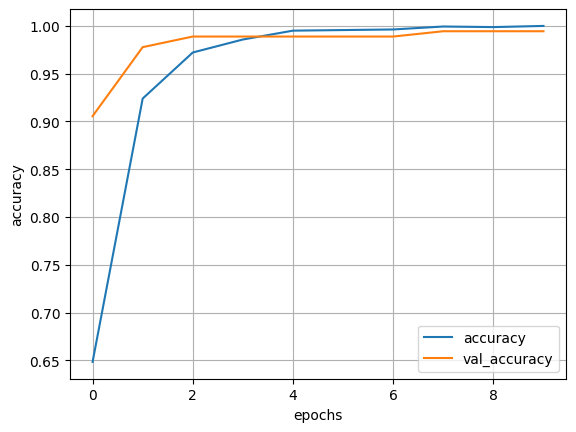

In [ ]:
#accuracy plot
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [ ]:
#model evaluation
testLoss_TL, testAccuracy_TL = model.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 577ms/step - accuracy: 1.0000 - loss: 0.0541
Test-loss: 0.055668, Test-accuracy: 1.000000


In [ ]:
#loading the best weights
model.load_weights("/content/drive/MyDrive/model 3/bestTL.weights.h5")

testLoss_TL, testAccuracy_TL = model.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0729
Test-loss: 0.075747, Test-accuracy: 1.000000


In [ ]:
y_proba = model.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step
[1 2 1 2 3 3 3 1 0 1 0 1 3 4 1 2 2 3 1 4 3 4 1 4 1 2 2 3 0 2 1 1 3 1 1 4 3
 1 0 0 4 0 4 4 2 4 2 1 4 3 4 1 0 4 2 0 4 1 2 0 1 2 4 3 0 0 3 2 4 2 0 3 2 2
 4 3 1 2 4 0 1 2 3 1 0 0 2 1 4 3 0 0 0 1 3 3 0 3 4 1 2 4 0 0 4 1 3 1 4 2 1
 3 1 2 2 1 2 4 2 1 2 2 4 2 3 0 4 0 2 2 2 0 4 0 2 1 3 0 0 2 3 2 0 2 2 2 1 3
 3 0 3 1 3 3 3 0 0 2 2 3 0 1 2 0 3 3 0 3 4 1 1 2 0 3 2 4 2 4 3 2 3 4 2 3 4
 1 4 2 4 0 1 1 1 1 1 1 1 4 4 0 0 4 1 4 0 2 0 4 2 1 4 2 3 4 1 4 3 3 3 4 0 4
 4 0 2 0 0 3 1 3 2 1 3 1 2 2 4 1 1 4 3 4 3 0 2 0 4 3 2 3 0 2 1 3 3 2 1 4 3
 0 0 0 0 3 2 0 2 1 0 1 4 1 2 2 3 3 4 2 0 3 1 2 4 0 1 0 1 4 4 2 1 2 4 2 1 1
 1 1 3 2 0 0 2 2 2 0 2 3 1 0 3 3 1 0 3 0 3 3 3 0 2 1 4 2 1 0 2 1 0 3 4 2 4
 0 3 2 0 3 0 4 1 2 3 0 1 2 3 2 4 1 0 4 0 4 4 0 4 1 1 3 4 2 2 3 3 0 1 2 3 1
 2 1 1 0 3 2 2 1 3 1 4 2 0 0 1 3 1 3 3 1 1 2 0 0 2 4 2 0 3 2 2 3 4 4 1 4 3
 4 3 3 0 4 2 4 4 1 2 0 2 4 3 4 1 1 2 3 2 2 3 3 2 3 3 0 1 0 0 1 4 3 2 3 3 1
 4 1 0 4 4 0 1 2 2 0 2 3 0 1 1 1 3 3 0 4 1 4 3 2 0 0 2 0 3 

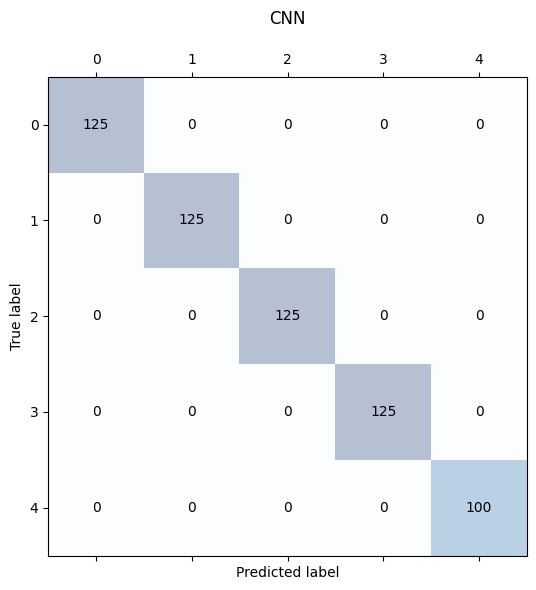

{0, 1, 2, 3, 4}
['Damask Rose' 'Echeveria Flower' 'Mirabilis Jalapa' 'Rain Lily'
 'Zinnia Elegans']


In [ ]:
#generating the confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

print(set(y))
print(label_encoder.classes_)


In [ ]:
#precision,recall and f1 score
pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

Precision:  1.0
Recall:  1.0
F1-score:  1.0






In [ ]:
# Saves the best model obtained
model.save('/content/drive/MyDrive/model 3/m3Best_Model.h5')

In [ ]:
from numpy import save

save('/content/drive/MyDrive/model 3/X_train_std.npy', X_train_std)
save('/content/drive/MyDrive/model 3/X_test_std.npy', X_test_std)

save('/content/drive/MyDrive/model 3/y_train.npy', y_train)
save('/content/drive/MyDrive/model 3/y_test.npy', y_test)